# Marginal Likelihood in Python and PyMC3

This is a paper reading of [A Tutorial on Bridge Sampling](https://arxiv.org/abs/1703.05984), which gives an excellent review of the computation of Marginal likelihood. Here I will replicate these computations in Python and PyMC3, using especially the Bridge sampling technique. An R implementation of Bridge sampling is available on [Github](https://github.com/quentingronau/bridgesampling) with [the paper](https://arxiv.org/pdf/1710.08162.pdf).  

**!Warning!: Marginal Likelihood (and Bayes Factor) is extremely sensitive to your model parameterisation (particularly the priors). You should be aware of which part of the model the Marginal Likelihood is sensitive to, and have a clear justification of these parts. Otherwise, Marginal Likelihood and Bayes Factors are too easy to game.**

In [1]:
import numpy as np
import pymc3 as pm
import scipy.stats as st
import seaborn as sns
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


The marginal likelihood is defined as follow:  

$$
p(y \mid \text{Model}) = \int p(y \mid \theta, \text{Model}) p(\theta \mid \text{Model}) d \theta
$$
where $y$ is the observed data, and $\text{Model}$ is the model/parameterization. If you interprete the marginal likelihood can be interpreted as a weighted average of the likelihood of the data given the prior $p(\theta \mid \text{Model})$, you can rewrite marginal likelihood as an expectation:  

$$
p(y \mid \text{Model}) = \mathbb{E}_{prior} [ p(y \mid \theta, \text{Model}) ]
$$

The upside of thinking regarding Expectation is in Monte Carlo simulation; we can think of simulate samples and perform average.

## The Running Example: The Beta-Binomial Model

$$ \theta \sim \text{Beta}(1,1) $$
$$ k \sim \text{Binomial}(\theta,n)$$

With a Conjugate prior, this becomes a Beta-Binomial model where the analytical solution is aviable:  
Posterior
$$ \theta \mid n, k \sim \text{Beta}(k+1, n-k+1) $$
and the marginal
$$ p (k \mid n) = \int^1_0 p (k \mid \theta, n) p (\theta) d (\theta) = \dfrac{1}{n+1}$$

In [2]:
# Observed Data
k = 2
n = 10
alpha = beta = 1

### The Analytical Solution

In [3]:
# 0. Exact Calculation
m_l = 1/(n + 1)
print('The analytical solution of the marginal likelihood is %.5f'%(m_l))

The analytical solution of the marginal likelihood is 0.09091


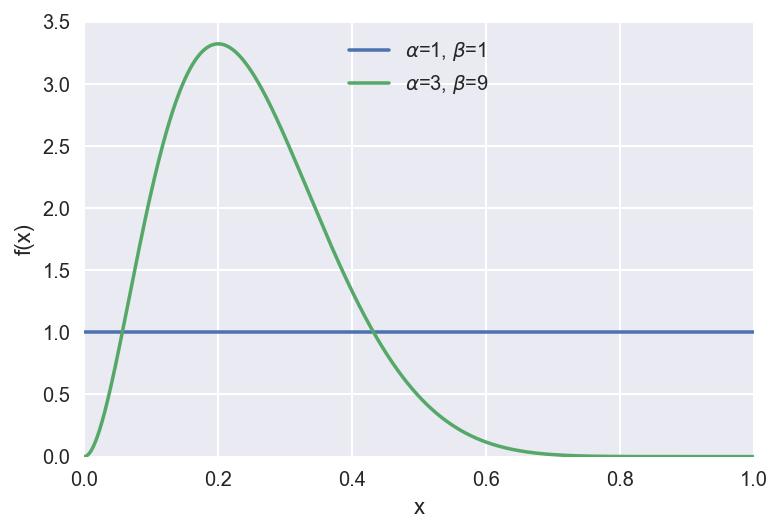

In [4]:
x = np.linspace(0.0, 1.0, 1000)
f = lambda a, b : st.beta.pdf(x, a, b)

fig, ax = plt.subplots()
plot_pdf = lambda a, b : ax.plot(x, f(a,b), label=r'$\alpha$={0}, $\beta$={1}'.format(a,b))
plot_pdf(alpha, beta)
plot_pdf(k+alpha, n-k+beta)
plt.legend(loc='upper center', frameon=False)
ax.set(xlim=[0,1], ylim=[0,3.5], xlabel='x', ylabel='f(x)')
plt.show()

### The Naive Monte Carlo Estimator

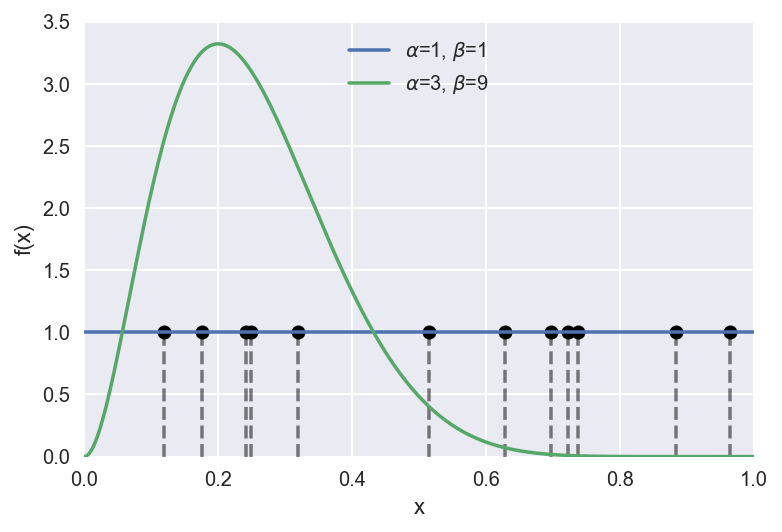

The Naive Monte Carlo Estimation is 0.11309


In [5]:
N=12
prior_samples = st.beta.rvs(alpha, beta, size=N)

fig, ax = plt.subplots()
betap = st.beta.pdf(prior_samples, alpha, beta)
ax.plot(prior_samples, betap, 'ko')
ax.plot([prior_samples, prior_samples],
        [np.zeros_like(betap), betap], 'k--', alpha=.5)

plot_pdf(alpha, beta)
plot_pdf(k+alpha, n-k+beta)
plt.legend(loc='upper center', frameon=False)
ax.set(xlim=[0, 1], ylim=[0, 3.5], xlabel='x', ylabel='f(x)')
plt.show()

m_l_n = st.binom.pmf(k, n, p=prior_samples).mean()
print('The Naive Monte Carlo Estimation is %.5f'%(m_l_n))

Naive Monte Carlo Estimation using PyMC3 model

In [6]:
# Set up PyMC3 model
with pm.Model() as BB:
    p = pm.Beta('p', alpha=1., beta=1., transform=None)
    obs = pm.Binomial('obs', p=p, n=n, observed=k)

In [7]:
from pymc3.model import Point
from pymc3.blocking import DictToArrayBijection, ArrayOrdering

start = Point(BB.test_point, model=BB)
bij = DictToArrayBijection(ArrayOrdering([p]), start)
logp_func = bij.mapf(obs.fastlogp_nojac)

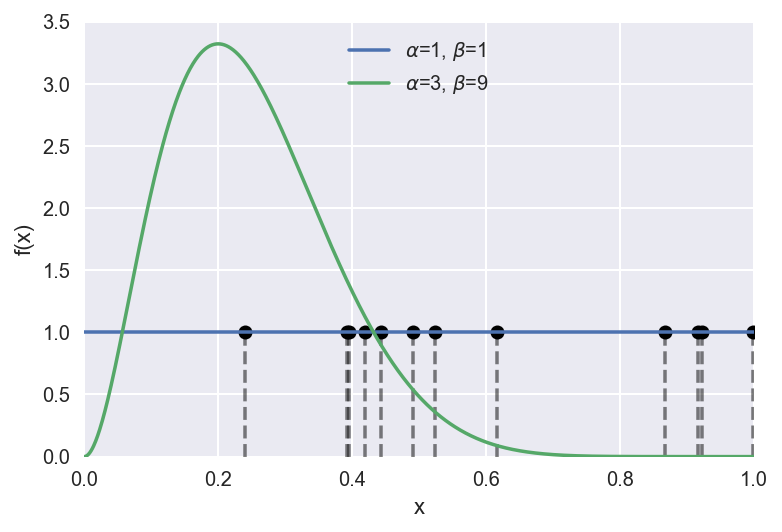

The Naive Monte Carlo Estimation is 0.06810


In [8]:
prior_samples = p.random(size=N)

fig, ax = plt.subplots()
betap = st.beta.pdf(prior_samples, alpha, beta)
ax.plot(prior_samples, betap, 'ko')
ax.plot([prior_samples, prior_samples],
        [np.zeros_like(betap), betap], 'k--', alpha=.5)
plot_pdf(alpha, beta)
plot_pdf(k+alpha, n-k+beta)
plt.legend(loc='upper center', frameon=False)
ax.set(xlim=[0,1], ylim=[0,3.5], xlabel='x', ylabel='f(x)')
plt.show()

m_l_n = np.exp(np.array([logp_func(p) for p in prior_samples])).mean()
print('The Naive Monte Carlo Estimation is %.5f'%(m_l_n))

### The Importance Sampling Estimator

In [9]:
# Draw from the posterior and create a Important Density g_IS(theta)
post_samples = st.beta.rvs(k+alpha, n-k+beta, size=N)

# use properties from the posterior in order to create g
mu_post = np.mean(post_samples)
var_post = np.var(post_samples)

# use method of moments to obtain best fitting beta distribution
a_g = mu_post*(mu_post*(1 - mu_post)/var_post - 1)
b_g = (1 - mu_post)*(mu_post*(1 - mu_post)/var_post - 1)

# mixture distribution
def betamix_pdf(x, w, a_g, b_g):
    return w*st.beta.pdf(x, alpha, beta) + (1-w)*st.beta.pdf(x, a_g, b_g)

# mixture samples
def betamix_rvs(N, w, a_g, b_g):
    mix_ind = np.random.choice(2, N, p=[w, 1-w])
    betamix_rv = np.hstack((st.beta.rvs(alpha, beta, size=(N, 1)),
                             st.beta.rvs(a_g, b_g, size=(N, 1))))
    return betamix_rv[range(N), mix_ind]

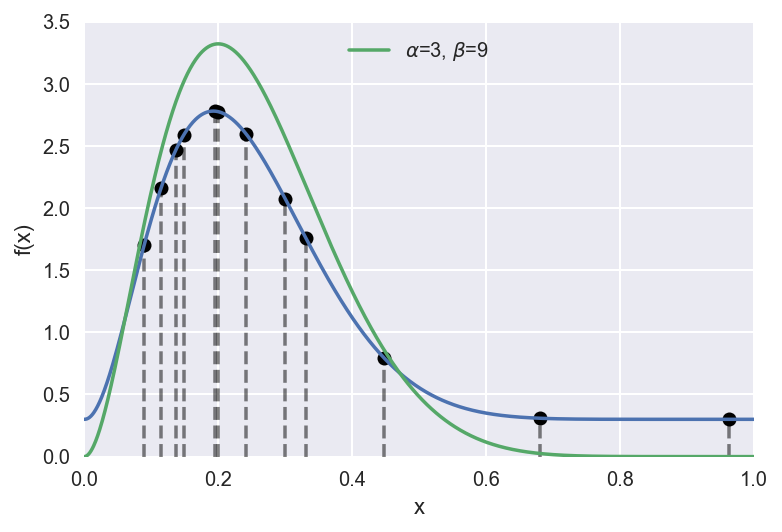

The Importance Sampling Estimation is 0.08941


In [10]:
w = .3
g_samples = betamix_rvs(N, w, a_g, b_g)

fig, ax = plt.subplots()
betap = betamix_pdf(g_samples, w, a_g, b_g)
ax.plot(g_samples, betap, 'ko')
ax.plot([g_samples, g_samples],
        [np.zeros_like(betap), betap], 'k--', alpha=.5)
ax.plot(x, betamix_pdf(x, w, a_g, b_g))
plot_pdf(k+alpha, n-k+beta)
plt.legend(loc='upper center', frameon=False)
ax.set(xlim=[0,1], ylim=[0,3.5], xlabel='x', ylabel='f(x)')
plt.show()

m_l_i = (st.binom.pmf(k, n, p=g_samples)*st.beta.pdf(g_samples, alpha, beta)/
        betamix_pdf(g_samples, w, a_g, b_g)).mean()
print('The Importance Sampling Estimation is %.5f'%(m_l_i))

In [11]:
# Set up PyMC3 model
with pm.Model() as BB:
    p = pm.Beta('p', alpha=1., beta=1.)
    obs = pm.Binomial('obs', p=p, n=n, observed=k)
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:01<00:00, 616.65it/s]
/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.883866271957, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))


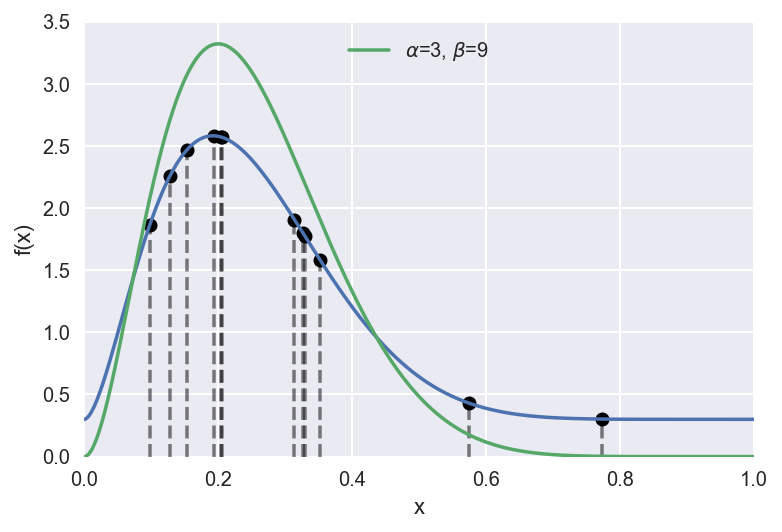

The Importance Sampling Estimation is 0.09677


In [12]:
post_samples = trace['p']

# use properties from the posterior in order to create g
mu_post = np.mean(post_samples)
var_post = np.var(post_samples)

# use method of moments to obtain best fitting beta distribution
a_g = mu_post*(mu_post*(1 - mu_post)/var_post - 1)
b_g = (1 - mu_post)*(mu_post*(1 - mu_post)/var_post - 1)

g_samples = betamix_rvs(N, w, a_g, b_g)

fig, ax = plt.subplots()
betap = betamix_pdf(g_samples, w, a_g, b_g)
ax.plot(g_samples, betap, 'ko')
ax.plot([g_samples, g_samples],
        [np.zeros_like(betap), betap], 'k--', alpha=.5)
ax.plot(x, betamix_pdf(x, w, a_g, b_g))
plot_pdf(k+alpha, n-k+beta)
plt.legend(loc='upper center', frameon=False)
ax.set(xlim=[0,1], ylim=[0,3.5], xlabel='x', ylabel='f(x)')
plt.show()

m_l_i = (st.binom.pmf(k, n, p=g_samples)*st.beta.pdf(g_samples, alpha, beta)/
        betamix_pdf(g_samples, w, a_g, b_g)).mean()
print('The Importance Sampling Estimation is %.5f'%(m_l_i))

### The Generalized Harmonic Mean Estimator

The Generalized Harmonic Mean is 0.08777


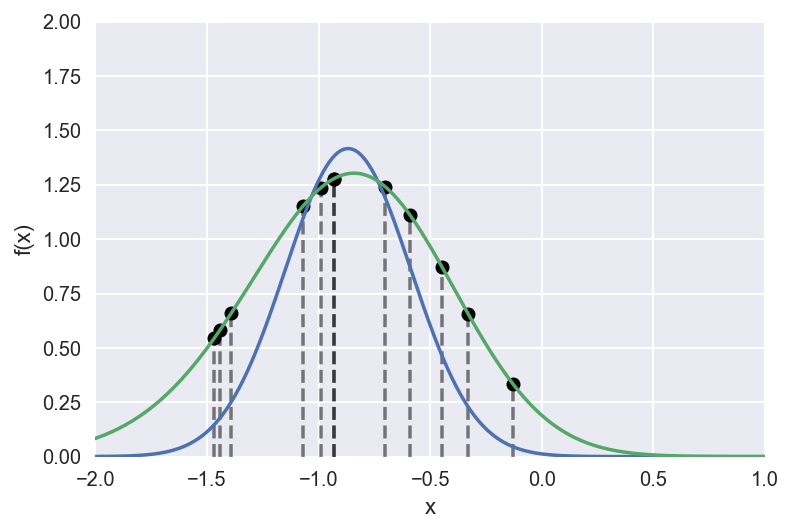

In [13]:
post_samples = st.beta.rvs(k+alpha, n-k+beta, size=N)

# probit-transform posterior samples
probit = st.norm.ppf
probit_post_samples = probit(post_samples)

scale = np.log(np.abs((2/np.sqrt(np.pi) * exp(-post_samples**2)).sum()))

mu_probit = np.mean(probit_post_samples)
sd_probit = np.std(probit_post_samples)

sd_g_is = sd_probit/1.5

m_l_gh = 1/(st.norm.pdf(probit_post_samples, mu_probit, sd_g_is)/
         (st.binom.pmf(k, n, p=post_samples)*
            st.norm.pdf(probit_post_samples, 0, 1))).mean()
print('The Generalized Harmonic Mean is %.5f'%(m_l_gh))

x1 = np.linspace(-2, 1, 1000)

fig, ax = plt.subplots()
betap = st.beta.pdf(post_samples, k+alpha, n-k+beta)
ax.plot(probit_post_samples, betap/scale, 'ko')
ax.plot([probit_post_samples, probit_post_samples],
        [np.zeros_like(betap), betap/scale], 'k--', alpha=.5)
ax.plot(x1, st.norm.pdf(x1, mu_probit, sd_g_is))
ax.plot(probit(x), st.beta.pdf(x, k+alpha, n-k+beta)/scale)
plt.legend(loc='upper center', frameon=False)
ax.set(xlim=[-2,1], ylim=[0,2], xlabel='x', ylabel='f(x)')
plt.show()

In [14]:
post_samples = trace['p']

# probit-transform posterior samples
probit_post_samples = probit(post_samples)

mu_probit = np.mean(probit_post_samples)
sd_probit = np.std(probit_post_samples)

sd_g_is = sd_probit/1.5

m_l_gh = 1/(st.norm.pdf(probit_post_samples, mu_probit, sd_g_is)/
         (st.binom.pmf(k, n, p=post_samples)*
            st.norm.pdf(probit_post_samples, 0, 1))).mean()
print('The Generalized Harmonic Mean is %.5f'%(m_l_gh))

The Generalized Harmonic Mean is 0.09260


In [15]:
post_samples = trace['p']
logit_samples = trace['p_logodds__']

mu_probit = np.mean(logit_samples)
sd_probit = np.std(logit_samples)

sd_g_is = sd_probit/2

m_l_gh = 1/(st.norm.pdf(logit_samples, mu_probit, sd_g_is)/
         (st.binom.pmf(k, n, p=post_samples)*
            st.norm.pdf(logit_samples, 0, 1))).mean()
print('The Generalized Harmonic Mean is %.5f'%(m_l_gh))

The Generalized Harmonic Mean is 0.09065


### The Bridge Sampling Estimator

In [19]:
# 1. We draw 2*N1 samples from the Beta(3, 9) posterior for theta.
N1 = 12
theta_star = st.beta.rvs(k+alpha, n-k+beta, size=N1*2)

# 2. We choose a proposal distribution 
# -> normal distribution

# 3. We transform the first batch of N1 posterior samples.
theta_star_4_fit = theta_star[:N1]
xi_star_4_fit = probit(theta_star_4_fit)

# 4. We fit the proposal distribution to the first batch of N1
#    probit-transformed posterior samples.
mu_hat = np.mean(xi_star_4_fit)
sigma_hat = np.std(xi_star_4_fit)

# 5. We draw N2 samples from the proposal distribution.
N2 = N1
xi_tilde = st.norm.rvs(mu_hat, sigma_hat, size=N2)

# 6. We calculate l_{2,i} for all N2 samples from the proposal.
def unnormalized_posterior(xi, k, n):
    # returns the unnormalized posterior density for xi
    return (st.binom.pmf(k, n, p=st.norm.cdf(xi))*
            st.norm.pdf(xi, 0, 1))

l2 = unnormalized_posterior(xi_tilde, k, n)/ \
    st.norm.pdf(xi_tilde, mu_hat, sigma_hat)

# 7. We transform the second batch of N1 posterior samples.
theta_star_4_iter = theta_star[N1+1:]
xi_star_4_iter = probit(theta_star_4_iter)

# 8. We calculate l_{1,j} for all N1 probit-transformed samples from
#    the posterior distribution.
l1 = unnormalized_posterior(xi_star_4_iter, k, n)/ \
    st.norm.pdf(xi_star_4_iter, mu_hat, sigma_hat)

# 9. We run the iterative scheme until our predefined tolerance criterion
#    is reached.

p4_y = 0 # initial guess of marginal likelihood
tol = 1e-10 # tolerance criterion
criterion_val = tol + 1 # criterion value

s1 = N1/(N1 + N2)
s2 = N2/(N1 + N2)

i = 0 # iteration counter
while criterion_val > tol:
    p4_y_old = p4_y
    # Equation 15
    numerator = l2/(s1*l2 + s2*p4_y)
    denominator = 1/(s1*l1 + s2*p4_y)
    p4_y = N1/N2*np.sum(numerator)/np.sum(denominator)
    i += 1
    criterion_val = abs((p4_y - p4_y_old)/p4_y)
    print("Iteration: %s -- Marginal likelihood estimate: %.5f"%(i, p4_y))

print('The Bridge Sampling Estimatation is %.5f'%(p4_y))

Iteration: 1 -- Marginal likelihood estimate: 0.11938
Iteration: 2 -- Marginal likelihood estimate: 0.09804
Iteration: 3 -- Marginal likelihood estimate: 0.10008
Iteration: 4 -- Marginal likelihood estimate: 0.09987
Iteration: 5 -- Marginal likelihood estimate: 0.09989
Iteration: 6 -- Marginal likelihood estimate: 0.09989
Iteration: 7 -- Marginal likelihood estimate: 0.09989
Iteration: 8 -- Marginal likelihood estimate: 0.09989
Iteration: 9 -- Marginal likelihood estimate: 0.09989
Iteration: 10 -- Marginal likelihood estimate: 0.09989
Iteration: 11 -- Marginal likelihood estimate: 0.09989
Iteration: 12 -- Marginal likelihood estimate: 0.09989
The Bridge Sampling Estimatation is 0.09989


In [16]:
st.norm.rvs?